In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Импортируем библиотеки

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling1D, Dense, Flatten, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from keras.preprocessing.image import load_img
from matplotlib import pyplot
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from keras.models import load_model

In [ ]:
def load_image(filename:str):
    '''Функция принимает на вход путь файла и возвращает изображение, представленное в виде массива'''
    # Загружаем изображение
    img = load_img(filename, target_size=(128, 128))
    # cпреобразуем в массив
    img = img_to_array(img)
    # Меняем размерность
    img = img.reshape(1, 128, 128, 3)
    # center pixel data
    img = img.astype('float32')
    return img

def pred(img_filem:str, model):
    '''Функция принимает на вход путь файла и модель, и выводит результат модели и файл'''
	# Применяем функцию load_image
    img = load_image(img_file)
	# Делаем предсказание по нашей модели    
    result = model.predict(img)
    classes = ['Cat', 'Dog']
    print(classes[round(result[0][0])])
    plt.axis('off')
    plt.imshow(Image.open(img_filem))

# Загружаем даттасет

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip -q kagglecatsanddogs_3367a.zip
!ls
!ls PetImages

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   138M      0  0:00:05  0:00:05 --:--:--  147M
replace PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace PetImages/Cat/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace PetImages/Cat/10.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace PetImages/Cat/100.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace PetImages/Cat/100.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
A
 drive			      'MSR-LA - 3467.docx'   sample_data
 kagglecatsanddogs_3367a.zip   PetImages
 model.png		      'readme[1].txt'
Cat  Dog


 # Удаляем битые и неподходящие файлы

In [ ]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)
print("Deleted %d images" % num_skipped)

Deleted 1087 images


# Формируем генератор тренировочной и тестовой выборки

In [ ]:
image_size = (128, 128)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

# Создаем HistoryCallback

In [ ]:
class HistoryCallback(keras.callbacks.Callback):
    def __init__(self):
        self.epochs = 0
        self.train_loss = []
        self.train_acc = []
        self.val_loss = []
        self.val_acc = []
        
        %matplotlib inline
        
    def on_epoch_end(self, epoch, logs=None):
        self.epochs += 1
        self.train_loss.append(logs['loss'])
        self.train_acc.append(logs['acc'])
        self.val_loss.append(logs['val_loss'])
        self.val_acc.append(logs['val_acc'])
        
    def on_train_end(self, epoch, logs=None):
        self.plot()
        
    def plot(self):
        fig, ax = plt.subplots(1,2, figsize=(10,5))
        
        ax[0].plot(self.train_loss, label='train loss')
        ax[0].plot(self.val_loss, label='val loss')
        ax[0].legend()
        ax[1].plot(self.train_acc, label='train acc')
        ax[1].plot(self.val_acc, label='val acc')
        ax[1].legend()
        plt.show()

# Тренируем на повороте фотографий

In [ ]:
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)
batch_size = 32
epochs = 10

# Загружаем, тренируем и применяем модель ResNet50

In [ ]:
try_model = ResNet50(weights='imagenet', include_top=False)
        
x = try_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
        
model_1 = Model(inputs=try_model.input, outputs=predictions)
        
parth = int(len(model_1.layers)*0.7)
        
for layer in try_model.layers[:parth]:
    layer.trainable = False
            
for layer in try_model.layers[parth+1:]:
    layer.trainable = True
            
model_1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy',metrics='acc')
        
print(ResNet50, '\n')
print(model_1.fit(train_ds, batch_size=batch_size, epochs=epochs, validation_data=val_ds),'\n')

<function ResNet50 at 0x7f86c44de7a0> 

Epoch 1/10
586/586 [==============================] - 102s 165ms/step - loss: 0.2766 - acc: 0.9173 - val_loss: 0.1526 - val_acc: 0.9383
Epoch 2/10
586/586 [==============================] - 96s 164ms/step - loss: 0.1105 - acc: 0.9568 - val_loss: 0.1168 - val_acc: 0.9532
Epoch 3/10
586/586 [==============================] - 96s 163ms/step - loss: 0.0812 - acc: 0.9697 - val_loss: 0.1649 - val_acc: 0.9370
Epoch 4/10
586/586 [==============================] - 96s 163ms/step - loss: 0.0583 - acc: 0.9783 - val_loss: 0.1897 - val_acc: 0.9389
Epoch 5/10
586/586 [==============================] - 96s 164ms/step - loss: 0.0439 - acc: 0.9835 - val_loss: 0.3281 - val_acc: 0.9291
Epoch 6/10
586/586 [==============================] - 96s 163ms/step - loss: 0.0376 - acc: 0.9861 - val_loss: 0.3995 - val_acc: 0.9404
Epoch 7/10
586/586 [==============================] - 96s 163ms/step - loss: 0.0459 - acc: 0.9840 - val_loss: 0.3450 - val_acc: 0.9165
Epoch 8/10
586

Cat


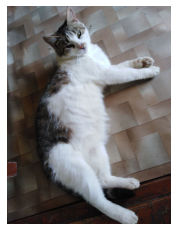

In [ ]:
path_cat = '/content/drive/MyDrive/Elbrus/Cat2.jpg'
path_dog = '/content/drive/MyDrive/Elbrus/Dog.jpg'
img_file = path_cat
pred(img_file, model_1)

# Загружаем, тренируем и применяем модель DenseNet121

In [ ]:
try_model = DenseNet121(weights='imagenet', include_top=False)
        
x = try_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
        
model_2 = Model(inputs=try_model.input, outputs=predictions)
        
parth = int(len(model_2.layers)*0.7)
        
for layer in try_model.layers[:parth]:
    layer.trainable = False
            
for layer in try_model.layers[parth+1:]:
    layer.trainable = True
            
model_2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy',metrics='acc')
        
print(DenseNet121, '\n')
print(model_2.fit(train_ds, batch_size=batch_size, epochs=epochs, validation_data=val_ds),'\n')

<function DenseNet121 at 0x7f86c4532950> 

Epoch 1/10
586/586 [==============================] - 95s 147ms/step - loss: 0.4732 - acc: 0.8104 - val_loss: 0.8578 - val_acc: 0.6755
Epoch 2/10
586/586 [==============================] - 83s 142ms/step - loss: 0.2788 - acc: 0.8840 - val_loss: 0.2431 - val_acc: 0.9019
Epoch 3/10
586/586 [==============================] - 83s 141ms/step - loss: 0.2333 - acc: 0.9025 - val_loss: 0.2414 - val_acc: 0.8904
Epoch 4/10
586/586 [==============================] - 83s 142ms/step - loss: 0.2073 - acc: 0.9158 - val_loss: 0.3814 - val_acc: 0.8607
Epoch 5/10
586/586 [==============================] - 84s 142ms/step - loss: 0.1816 - acc: 0.9262 - val_loss: 0.2335 - val_acc: 0.9084
Epoch 6/10
586/586 [==============================] - 83s 141ms/step - loss: 0.1589 - acc: 0.9356 - val_loss: 0.2624 - val_acc: 0.8930
Epoch 7/10
586/586 [==============================] - 82s 140ms/step - loss: 0.1395 - acc: 0.9439 - val_loss: 0.3430 - val_acc: 0.8780
Epoch 8/10
5

Cat


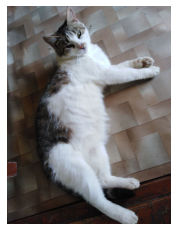

In [ ]:
img_file = path_cat
pred(img_file, model_2)

# Создаем свою нейронную сеть

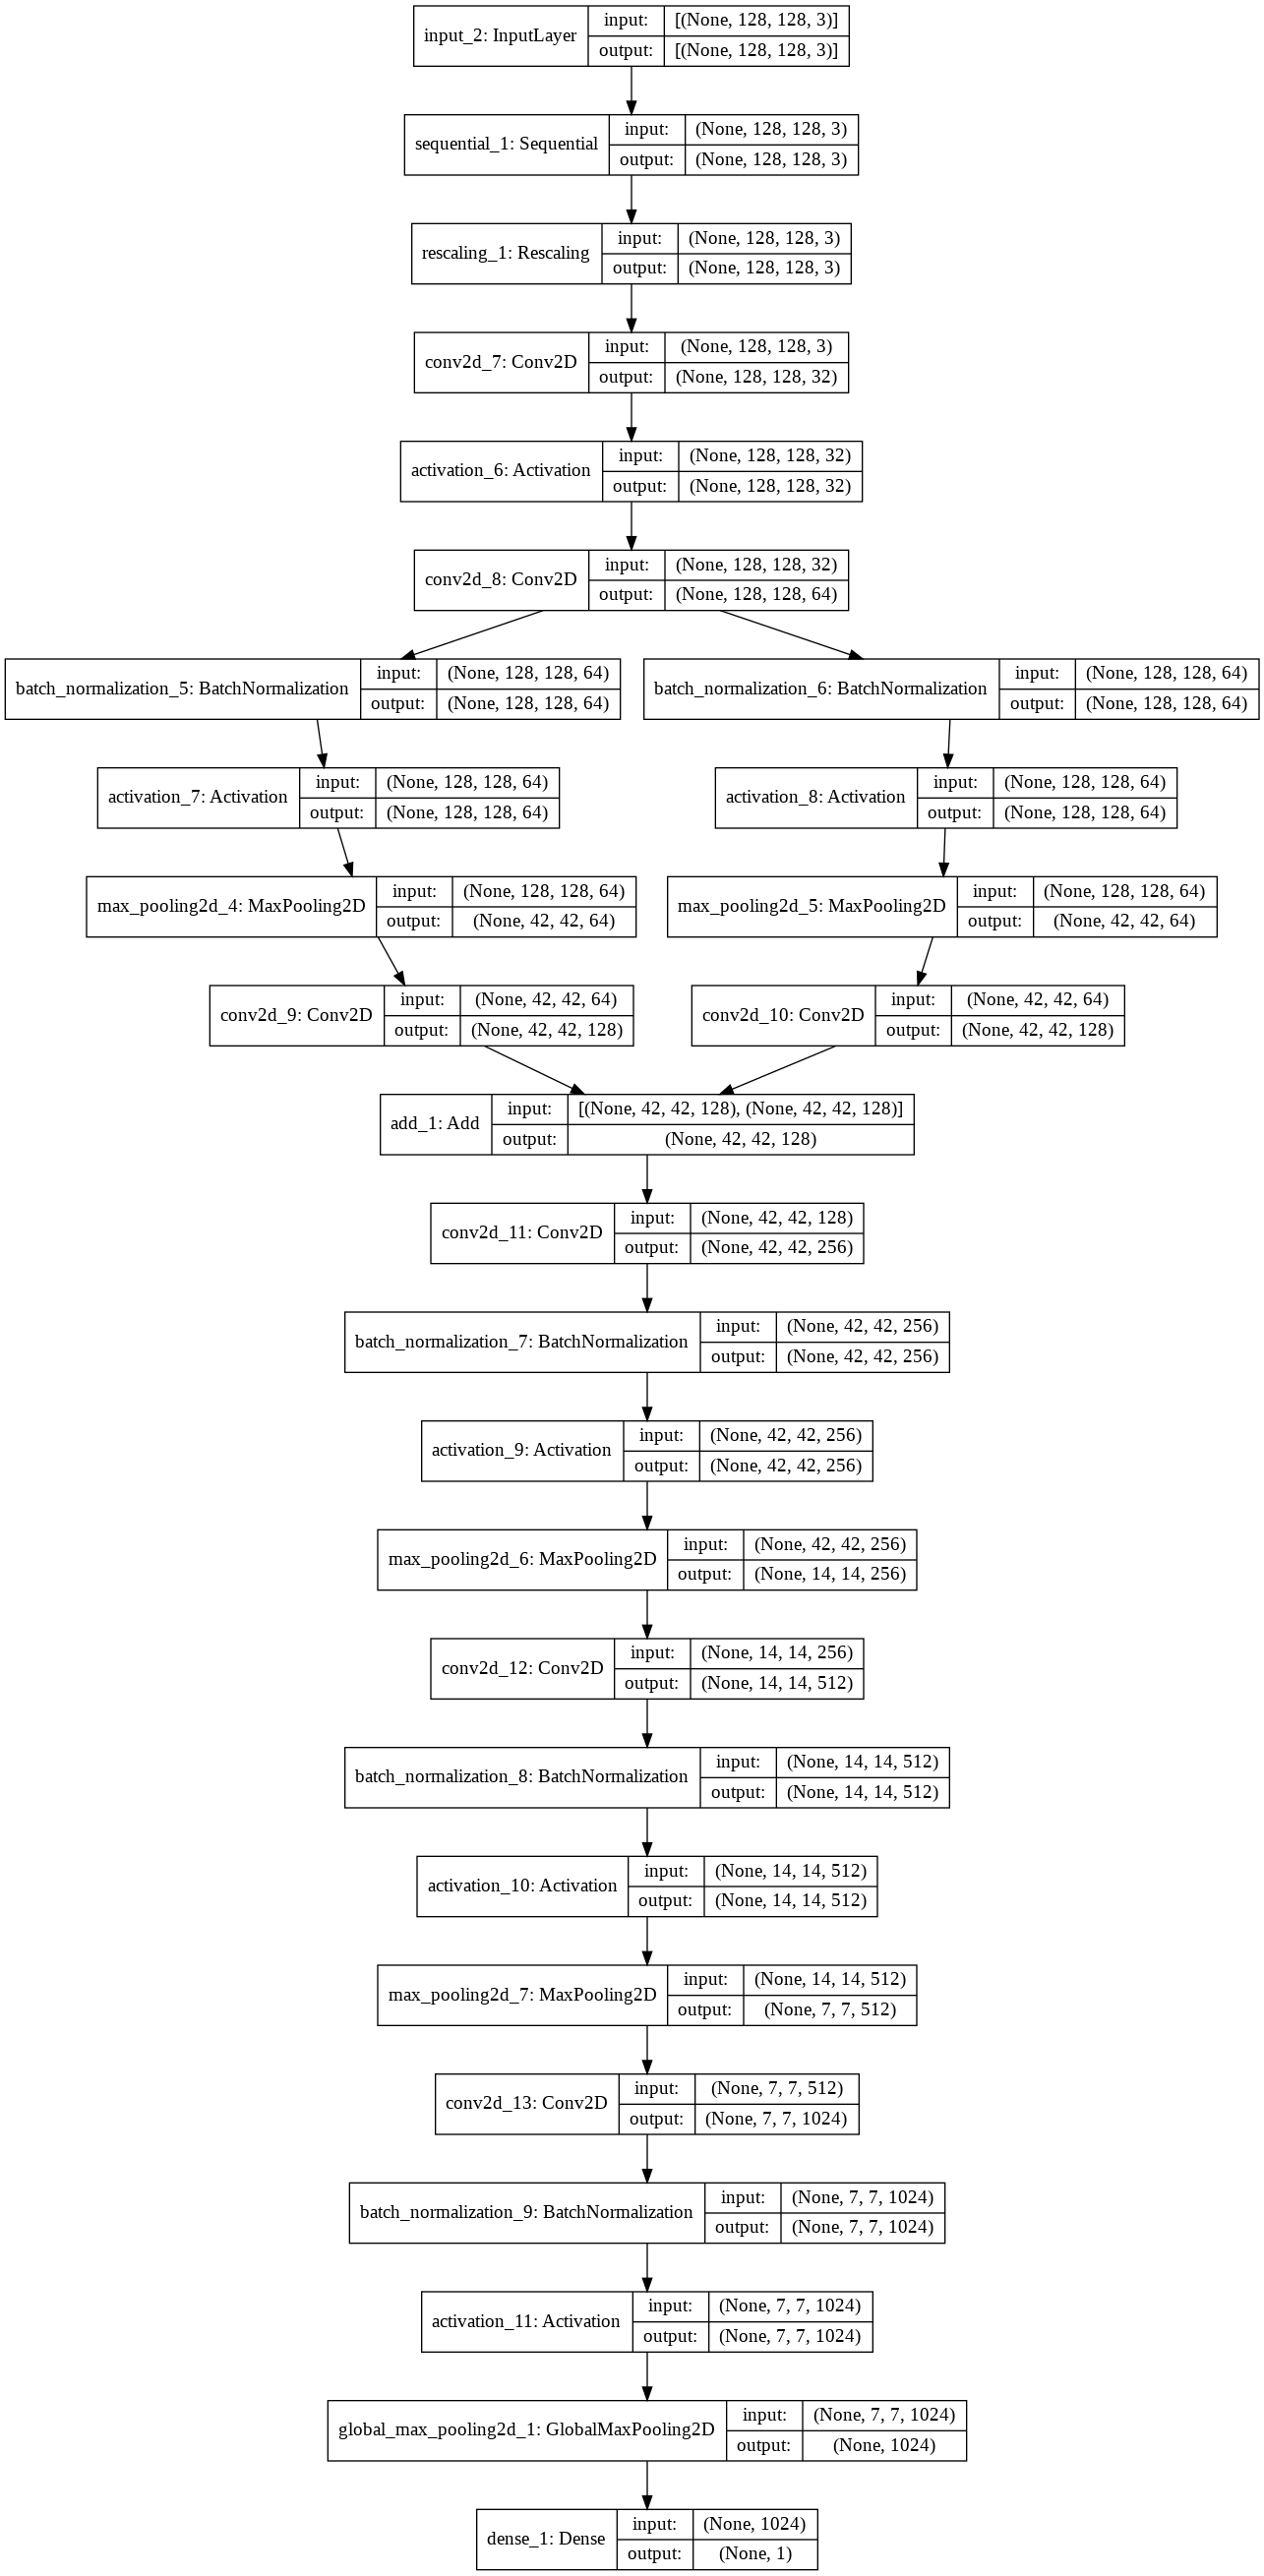

In [ ]:
def Net ():
    '''Функция нейронной сети с выходным полносвязным слоем активации sigmoig и с применением GlobalMaxPooling2D.'''
    input_shape = (128, 128, 3)
    model = keras.Sequential
    inputs = keras.Input(shape=input_shape)
    dense_1 = data_augmentation(inputs)
    dense_1 = tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)(dense_1)
    dense_1 = layers.Conv2D(32, 3, strides=1, padding='same')(dense_1)
    dense_1 = layers.Activation('relu')(dense_1)
    
    dense_common = layers.Conv2D(64, 3, padding='same')(dense_1) 
    
    dense_2 = layers.BatchNormalization()(dense_common)
    dense_2 = layers.Activation('relu')(dense_2)
    dense_2 = layers.MaxPooling2D(3)(dense_2)
    dense_2 = layers.Conv2D(128, 3, padding='same')(dense_2)
    
    dense_3 = layers.BatchNormalization()(dense_common)
    dense_3 = layers.Activation('relu')(dense_3)
    dense_3 = layers.MaxPooling2D(3)(dense_3)  
    dense_3 = layers.Conv2D(128, 3, padding='same')(dense_3)
    
    dense_4 = layers.add([dense_2,dense_3])
    dense_4 = layers.Conv2D(256,3,padding='same')(dense_4)
    dense_4 = layers.BatchNormalization()(dense_4)
    dense_4 = layers.Activation('relu')(dense_4)
    
    dense_4 = layers.MaxPooling2D(3)(dense_4)
    dense_4 = layers.Conv2D(512,3,padding='same')(dense_4)
    dense_4 = layers.BatchNormalization()(dense_4)
    dense_4 = layers.Activation('relu')(dense_4)
    
    dense_4 = layers.MaxPooling2D(2)(dense_4)
    dense_4 = layers.Conv2D(1024,3,padding='same')(dense_4)
    dense_4 = layers.BatchNormalization()(dense_4)
    dense_4 = layers.Activation('relu')(dense_4)   
    
    dense_4 = layers.GlobalMaxPooling2D()(dense_4)
    
    outputs = layers.Dense(1, activation = 'sigmoid')(dense_4)
    return keras.Model(inputs, outputs)
model = Net()
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128, 128, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 128, 128, 3)  0           sequential_1[0][0]               
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 128, 128, 32) 896         rescaling_1[0][0]                
____________________________________________________________________________________________

In [ ]:
history = HistoryCallback()
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", # по какому параметру будем останавливать
    patience=10, # сколько эпох подряд качество не должно улучшаться для остановки
    restore_best_weights=False # также можно восстанавливать лучшие веса после остановки (откатываться на 5 эпох назад)
)
model.compile(loss="binary_crossentropy", 
              optimizer=Adam(learning_rate=0.01), 
              metrics='acc')

# Обучаем модель

Epoch 1/15
586/586 [==============================] - 119s 200ms/step - loss: 0.8627 - acc: 0.5697 - val_loss: 1.1384 - val_acc: 0.5043
Epoch 2/15
586/586 [==============================] - 117s 199ms/step - loss: 0.6491 - acc: 0.6464 - val_loss: 0.8101 - val_acc: 0.5143
Epoch 3/15
586/586 [==============================] - 117s 200ms/step - loss: 0.5142 - acc: 0.7474 - val_loss: 0.4455 - val_acc: 0.7969
Epoch 4/15
586/586 [==============================] - 117s 199ms/step - loss: 0.3959 - acc: 0.8183 - val_loss: 0.4074 - val_acc: 0.8144
Epoch 5/15
586/586 [==============================] - 118s 200ms/step - loss: 0.3411 - acc: 0.8507 - val_loss: 0.4440 - val_acc: 0.7740
Epoch 6/15
586/586 [==============================] - 118s 201ms/step - loss: 0.2871 - acc: 0.8733 - val_loss: 0.2929 - val_acc: 0.8733
Epoch 7/15
586/586 [==============================] - 118s 200ms/step - loss: 0.2557 - acc: 0.8895 - val_loss: 0.3402 - val_acc: 0.8428
Epoch 8/15
586/586 [============================

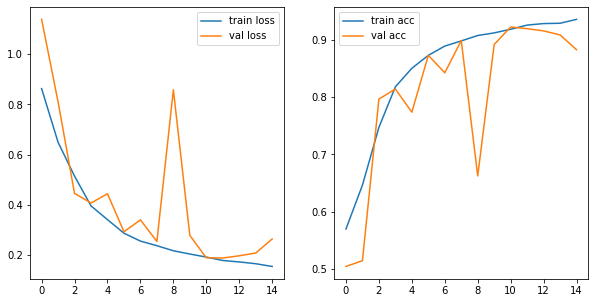

In [ ]:
model.fit(train_ds, batch_size=batch_size, epochs=epochs+5, validation_data=val_ds, callbacks=[history, early_stopping],verbose=1,use_multiprocessing=True)

Cat


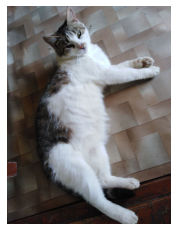

In [ ]:
path_cat = '/content/drive/MyDrive/Elbrus/Cat2.jpg'
path_dog = '/content/drive/MyDrive/Elbrus/Dog.jpg'
img_file = path_cat
pred(img_file, model)

Dog


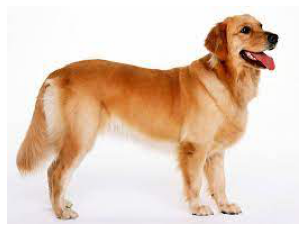

In [ ]:
img_file = path_dog
pred(img_file, model)